In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
import numpy as np
import os
from pyspark.sql.types import *
import pickle
import tensorflow as tf
from src.util import *
from sklearn.feature_extraction.text import CountVectorizer
import pyspark.sql.functions as F
import s3fs
# import nltk

# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# from pyspark.ml.feature import CountVectorizer, IDF
# from pyspark.sql.functions import udf
# from pyspark.sql import Row
# PUNCTUATION = set(string.punctuation)
# STOPWORDS = set(stopwords.words('english'))


# import tensorflow_hub as hub
# from sklearn import preprocessing
# import codecs
# import string
# import re
# from pyspark.sql.functions import isnan, when, count, col
# import spacy
# from spacy.lang.en import English
# from spacy import displacy
# nlp = spacy.load('en_core_web_md')
# import logging
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Load Data

In [2]:
df = spark.read.json(
 's3://aws-logs-816063959671-us-east-1/data/tldr-training-data.jsonl')


In [3]:
subset = df.sample(withReplacement=False, fraction=0.1)
subset.cache()
subset.count()

308179

In [4]:
subset.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- content: string (nullable = true)
 |-- content_len: long (nullable = true)
 |-- id: string (nullable = true)
 |-- normalizedBody: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- summary_len: long (nullable = true)
 |-- title: string (nullable = true)



In [5]:
from src.util import *

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import numpy as np
import string
import re
from pyspark.sql.functions import isnan, when, count, col
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import Row
import pyspark.sql.functions as F
import pickle
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
addl_punctuation = set(['...', '`', '¿','⸮', '``', "''"])
PUNCTUATION = PUNCTUATION.union(addl_punctuation)

CONTRACTIONS = {
"ain't": "am not", "aren't": "are not", "can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have",
"he'll": "he will","he's": "he is","how'd": "how did","how'll": "how will",
"how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not",
"it'd": "it would","it'll": "it will","it's": "it is","let's": "let us", "ma'am": "madam", "mayn't": "may not",
"might've": "might have","mightn't": "might not","must've": "must have","mustn't": "must not",
"needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would",
"that's": "that is","there'd": "there had","there's": "there is","they'd": "they would","they'll": "they will",
"they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would","we'll": "we will",
"we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are",
"what's": "what is","what've": "what have","where'd": "where did","where's": "where is","who'll": "who will",
"who's": "who is","won't": "will not","wouldn't": "would not","you'd": "you would","you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords=True):
    text = text.lower()

    if True:
        text = text.split()
        new_text = [CONTRACTIONS[w] if w in CONTRACTIONS else w for w in text]

        text = " ".join(new_text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    if remove_stopwords==True:
        tokens = [w for w in tokens if w not in STOPWORDS]
    return ' '.join(tokens)

def word_length(string):
    tokens = word_tokenize(string)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    return len(tokens)

def clean_data(df, n_words_summary=50, remove_stopwords=True):
    # Get rid of all rows where subreddit is null (these are spam)
    df = df.filter(df.subreddit.isNotNull())
    # Lowercase columns:
    for col in ['body','content','normalizedBody','subreddit','summary','title']:
        df = df.withColumn(col, F.lower(F.col(col)))
    # Converts 'null' strings in the title column back to null values
    df = df.withColumn('title', when(df.title == 'null', F.lit(None)).otherwise(df.title))
    

    # Creat edit(bool) and edit_len columns, while removing 'edit:%' from summary column
    split_col = F.split(df['summary'], '(edit:|[^a-z]edit)')
    df = df.withColumn('edit', split_col.getItem(1))
    df = df.withColumn('summary', split_col.getItem(0))
    function = udf(word_length, LongType())
    df = df.withColumn('summary_len', function(df.summary))
        # Creates edit_len column, number of words from 'edit'
    df = df.withColumn('edit', df.edit).na.fill('')
    df = df.withColumn('edit_len', function(df.edit))
        # Converts -1 in edit_len column to null
    df = df.withColumn('edit_len',
        when(df.edit_len == -1, F.lit(0)).otherwise(df.edit_len))
    df = df.withColumn('edit', when(df.edit.isNull(), F.lit(0)).otherwise(1))
    # Remove all rows where summary contains less than 5 words
    df = df.filter(df.summary_len >= 5)
    # Remove all rows where summary contains greater than n_words_summary words
    df = df.filter((df.summary_len <= n_words_summary))
    # Remove all rows where the summary length is not less than 50% of the content length
    df = df.filter(df.summary_len <= df.content_len*0.5)
    # Clean Content column
    cleantext_udf = udf(clean_text, StringType())
    df = df.withColumn('content', cleantext_udf(df.content, F.lit(remove_stopwords)))
    df = df.withColumn('summary', cleantext_udf(df.summary, F.lit(False)))
    return df

In [7]:
newdf = clean_data(subset)

In [8]:
newdf.count()

267460

In [9]:
pdf = newdf.toPandas()

In [10]:
pdf.drop(['body', 'normalizedBody', 'author', 'id', 'subreddit', 'subreddit_id',
         'title'], axis=1, inplace=True)

In [11]:
pdf.head()

,content,content_len,summary,summary_len,edit,edit_len
0,mechwarrior online begun use mouse turret aspe...,213,yes joysticks in modern games have apparently ...,19,1,0
1,used work mgm studios known disney 's hollywoo...,124,i knocked susan lucci on her ass,7,1,0
2,good audio/video quality including mics banter...,101,good job but more firefall talk,6,1,0
3,kids little 20 's always told look one another...,246,4th grader beat an 8th grade bully to bloody t...,10,1,0
4,think like mailing pages book different people...,166,always look for the highest seeded torrents an...,10,1,0


In [12]:
pdf = pdf.replace('', np.NaN)
pdf = pdf.replace(float('nan'), np.NaN)
pdf.dropna(inplace=True)

# Create Vocabulary

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
cv = CountVectorizer(strip_accents=ascii)
cv.fit_transform(pdf['content'])
vocab = cv.vocabulary_

In [15]:
len(vocab)

299734

### Convert glove vectors to pkl (which was later cp'd to S3)

In [16]:
# s3 = s3fs.S3FileSystem(anon=False)
# embeddings_index = {}
# with s3.open(
#     's3://aws-logs-816063959671-us-east-1/data/glove.42B.300d.txt',
#         'rb') as f:
#     for line in f:
#         values = line.split()
#         word = values[0] 
#         embedding = np.asarray(values[1:], dtype='float32') 
#         embeddings_index[word.decode('utf-8')] = embedding 

# with open('../data/glove_embeddings.pickle', 'wb') as handle:
#     pickle.dump(
#         embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
          
# print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

In [17]:
s3 = s3fs.S3FileSystem(anon=False)
with s3.open(
    's3://aws-logs-816063959671-us-east-1/data/glove_embeddings.pickle', 
    'rb') as handle:
    glove_embeddings = pickle.load(handle)

In [18]:
len(glove_embeddings)

1917495

In [27]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in vocab.items():
    if word not in glove_embeddings:
        missing_words += 1
            
missing_ratio = round(missing_words/len(vocab),4)*100
            
print("Number of words missing from glove embeddings:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))



Number of words missing from CN: 101320
Percent of words that are missing from vocabulary: 33.800000000000004%


In [28]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, _ in vocab.items():
    if word in glove_embeddings:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, idx in vocab_to_int.items():
    int_to_vocab[idx] = word

usage_ratio = round(len(vocab_to_int) / len(vocab),4)*100

print("Total number of unique words:", len(vocab))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 299734
Number of words we will use: 198418
Percent of words we will use: 66.2%


In [31]:
# Need to use 300 for embedding dimensions to match glove's vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in glove_embeddings:
        word_embedding_matrix[i] = glove_embeddings[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        glove_embeddings[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

198418


# Encode text and summaries

In [37]:
pdf.head()

,content,content_len,summary,summary_len,edit,edit_len
0,mechwarrior online begun use mouse turret aspe...,213,yes joysticks in modern games have apparently ...,19,1,0
1,used work mgm studios known disney 's hollywoo...,124,i knocked susan lucci on her ass,7,1,0
2,good audio/video quality including mics banter...,101,good job but more firefall talk,6,1,0
3,kids little 20 's always told look one another...,246,4th grader beat an 8th grade bully to bloody t...,10,1,0
4,think like mailing pages book different people...,166,always look for the highest seeded torrents an...,10,1,0


In [63]:
def convert_to_ints(row, column, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    sentence_ints = []
    for word in row[column].split():
        if word in vocab_to_int:
            sentence_ints.append(vocab_to_int[word])
        else:
            sentence_ints.append(vocab_to_int["<UNK>"])
    if eos:
        sentence_ints.append(vocab_to_int["<EOS>"])
    return sentence_ints


def unk_counter(row, column):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in row[column]:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [79]:
int_summary = pd.DataFrame(
    pdf.apply(convert_to_ints, axis=1, args=('summary',True)))
int_summary.columns = ['summary']
unk_summary = pd.DataFrame(
    int_summary.apply(unk_counter, axis=1, args=('summary',)))
unk_summary.columns = ['unk_count_summary']

int_content = pd.DataFrame(
    pdf.apply(convert_to_ints, axis=1, args=('content',True)))
int_content.columns = ['content']
unk_content = pd.DataFrame(
    int_content.apply(unk_counter, axis=1, args=('content',)))
unk_content.columns = ['unk_count_content']

dfs = [int_content, int_summaries, unk_content, unk_summary,
      pdf['content_len'], pdf['summary_len']]

encoded_df = pd.concat((dfs), axis=1)


In [80]:
encoded_df.head()

,content,summary,unk_count_content,unk_count_summary,content_len,summary_len
0,"[0, 1, 2, 3, 4, 5, 6, 7, 198414, 10, 11, 12, 1...","[2361, 23386, 2502, 25, 26, 1340, 1626, 1060, ...",6,1,213,19
1,"[100, 101, 102, 103, 104, 105, 198414, 106, 10...","[198414, 4412, 139, 140, 4229, 6700, 5133, 198...",3,1,124,7
2,"[168, 198414, 171, 172, 173, 174, 175, 176, 17...","[168, 1790, 12028, 6625, 206, 762, 198416]",3,0,101,6
3,"[215, 14, 216, 198414, 217, 218, 90, 219, 220,...","[227, 233, 254, 27677, 232, 225, 264, 4981, 25...",2,0,246,10
4,"[34, 134, 300, 301, 302, 303, 304, 305, 306, 3...","[217, 90, 1067, 1068, 471, 23309, 33216, 2934,...",9,0,166,10


In [81]:
encoded_df.describe()

,unk_count_content,unk_count_summary,content_len,summary_len
count,267459.000000,267459.000000,267459.000000,267459.000000
mean,3.788999,1.473994,208.916701,20.689294
std,5.298682,1.542533,80.302270,10.749811
min,0.000000,0.000000,100.000000,5.000000
25%,1.000000,0.000000,141.000000,12.000000
50%,3.000000,1.000000,192.000000,19.000000
75%,5.000000,2.000000,266.000000,27.000000
max,389.000000,35.000000,400.000000,50.000000


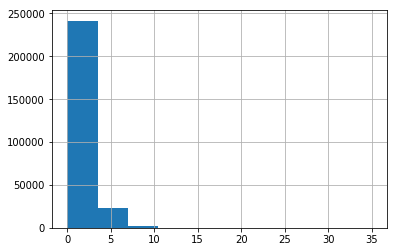

In [70]:
unk[0].hist()

# Model

In [209]:
import keras
from keras.layers import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors\

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from tensorflow.python.layers.core import Dense

In [210]:
# Set the Hyperparameters
epochs = 100
batch_size = 64
rnn_size = 256
num_layers = 2
learning_rate = 0.005
keep_probability = 0.75
rate = 1-keep_probability

In [211]:
len(vocab_to_int)

198418

# Define input params to encoder

In [212]:
def model_inputs():
    '''Create palceholders for inputs to the model'''
    
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')

    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length

def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

## Build encoder model

In [213]:
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    '''Create the encoding layer'''
    
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, 
                                                    input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, 
                                                    input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
    # Join outputs since we are using a bidirectional RNN
    enc_output = tf.concat(enc_output,2)
    
    return enc_output, enc_state[0]


# Decoding / Training process

In [214]:
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, initial_state, output_layer, 
                            vocab_size, max_summary_length):
    '''Create the training logits'''
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 

    training_logits, _ ,_ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                        output_time_major=False,
                                                        impute_finished=True,
                                                        maximum_iterations=max_summary_length)
    
    return training_logits

def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, initial_state, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,
                                                                start_tokens,
                                                                end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        initial_state,
                                                        output_layer)
                
    inference_logits, _ ,_ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                            output_time_major=False,
                                            impute_finished=True,
                                            maximum_iterations=max_summary_length)
    
    return inference_logits

def decoding_layer(dec_embed_input, embeddings, enc_output, enc_state, vocab_size, text_length, summary_length, 
                   max_summary_length, rnn_size, vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    with tf.name_scope("RNN_Decoder_Cell"):
        for layer in range(num_layers):
            with tf.variable_scope('decoder_{}'.format(layer)):
                lstm = tf.contrib.rnn.LSTMCell(rnn_size,
                                               initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
                dec_cell = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob)
    
    output_layer = Dense(vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                  enc_output,
                                                  text_length,
                                                  normalize=False,
                                                  name='BahdanauAttention')
    with tf.name_scope("Attention_Wrapper"):
        dec_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attn_mech, rnn_size)
    
    
    #initial_state = dec_cell.zero_state(batch_size=batch_size,dtype=tf.float32).clone(cell_state=enc_state)
    initial_state = dec_cell.zero_state(batch_size=batch_size,dtype=tf.float32).clone(cell_state=enc_state)
    
    with tf.variable_scope("decode"):
        training_logits = training_decoding_layer(dec_embed_input, 
                                                  summary_length, 
                                                  dec_cell, 
                                                  initial_state,
                                                  output_layer,
                                                  vocab_size, 
                                                  max_summary_length)
    with tf.variable_scope("decode", reuse=True):
        inference_logits = inference_decoding_layer(embeddings,  
                                                    vocab_to_int['<GO>'], 
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell, 
                                                    initial_state, 
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)

    return training_logits, inference_logits

In [215]:
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    '''Use the previous functions to create the training and inference logits'''
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

In [216]:
def pad_sentence_batch(sentence_batch):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentence_batch]

def get_batches(summaries, texts, batch_size):
    """Batch summaries, texts, and the lengths of their sentences together"""
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_sentence_batch(summaries_batch))
        pad_texts_batch = np.array(pad_sentence_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

In [217]:

# Set the Hyperparameters
epochs = 100
batch_size = 64
rnn_size = 256
num_layers = 2
learning_rate = 0.005
keep_probability = 0.75

In [218]:
# Build the graph
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits.rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
print("Graph is built.")

Graph is built.


# Training model

In [229]:
import time

In [223]:
encoded_df = encoded_df.sort_values(by='content_len', ascending=False)

In [225]:
test_df = encoded_df.sample(frac=0.1)

In [227]:
summary_short = test_df.summary
content_short = test_df.content

In [230]:
# Train the Model
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 20 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 3 # Make 3 update checks per epoch
update_check = (len(content_short)//batch_size//per_epoch)-1

update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model

checkpoint = "best_model.ckpt" 
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    #loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
    #loader.restore(sess, checkpoint)
    
    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths) in enumerate(
                get_batches(summary_short, content_short, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: texts_batch,
                 targets: summaries_batch,
                 lr: learning_rate,
                 summary_length: summaries_lengths,
                 text_length: texts_lengths,
                 keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(content_short) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
                    
        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 37286)
Traceback (most recent call last):
  File "/home/hadoop/anaconda/lib/python3.7/socketserver.py", line 313, in _handle_request_noblock
  File "/home/hadoop/anaconda/lib/python3.7/socketserver.py", line 344, in process_request
  File "/home/hadoop/anaconda/lib/python3.7/socketserver.py", line 357, in finish_request
  File "/home/hadoop/anaconda/lib/python3.7/socketserver.py", line 717, in __init__
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/lib/spark/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError
----------------------------------------


ResourceExhaustedError: OOM when allocating tensor with shape[64,49,198419] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[node decode/decoder/transpose (defined at <ipython-input-214-7cd1f6deff1f>:17) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'decode/decoder/transpose', defined at:
  File "/home/hadoop/anaconda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
  File "/home/hadoop/anaconda/lib/python3.7/runpy.py", line 85, in _run_code
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
  File "/home/hadoop/anaconda/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
  File "/home/hadoop/anaconda/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
  File "/home/hadoop/anaconda/lib/python3.7/asyncio/events.py", line 88, in _run
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
  File "<ipython-input-218-2482e3ce02af>", line 20, in <module>
    batch_size)
  File "<ipython-input-215-605aa3e33839>", line 26, in seq2seq_model
    num_layers)
  File "<ipython-input-214-7cd1f6deff1f>", line 75, in decoding_layer
    max_summary_length)
  File "<ipython-input-214-7cd1f6deff1f>", line 17, in training_decoding_layer
    maximum_iterations=max_summary_length)
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/contrib/seq2seq/python/ops/decoder.py", line 337, in dynamic_decode
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/util/nest.py", line 381, in map_structure
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/util/nest.py", line 381, in <listcomp>
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/ops/rnn.py", line 64, in _transpose_batch_time
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1674, in transpose
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 10238, in transpose
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
  File "/home/hadoop/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,49,198419] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[node decode/decoder/transpose (defined at <ipython-input-214-7cd1f6deff1f>:17) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

